In [1]:
import cv2
import numpy as np 
import os
import matplotlib.pyplot as plt
import pickle 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

2024-10-14 16:51:30.028420: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 16:51:30.036598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 16:51:30.046724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 16:51:30.049707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 16:51:30.057088: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Defining Variables

In [4]:
DATA_DIR = "fight-detection-surv-dataset"
CLASS_NAMES = ["fight","noFight"]
SEQUENCE_LENGTH = 8
IMG_HEIGHT , IMG_WIDTH = 150,150
BATCHES = 32
CHANNELS = 3
INPUT_SHAPE = (SEQUENCE_LENGTH,IMG_HEIGHT,IMG_WIDTH,CHANNELS)
LABEL_POSITION = (10, 30) #(x,y)
LABEL_FONT = cv2.FONT_HERSHEY_SIMPLEX
LABEL_FONT_SIZE = 0.8
LABEL_COLOR = (0, 0, 255)  # White color in BGR
LABEL_THICKNESS = 2

In [5]:
def frame_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
        success,frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame,(IMG_HEIGHT,IMG_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return np.asarray(frames_list)
    

In [6]:
def create_dataset():
    features = []
    labels = []
    video_file_paths = []
    for class_index,class_name in enumerate(CLASS_NAMES):
        print(class_name)
        files_path = os.listdir(os.path.join(DATA_DIR,class_name))
        for file_name in files_path:
            video_file_path = os.path.join(DATA_DIR,class_name,file_name)
            frames = frame_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_file_paths.append(video_file_path)
    features = np.asarray(features)
    lables = np.array(labels)
    return features,labels,video_file_paths

In [7]:
features,labels,video_file_paths = create_dataset()

fight
noFight


In [8]:
features.shape

(300, 8, 150, 150, 3)

In [9]:
encoded_labels = tf.keras.utils.to_categorical(labels)

In [10]:
from sklearn.model_selection import train_test_split
features_train,features_test,lables_train,labels_test = train_test_split(features,encoded_labels,test_size=0.3)

In [11]:
cnn_lstm_model = Sequential([
    InputLayer(shape=INPUT_SHAPE),
    TimeDistributed(Conv2D(filters=32,kernel_size=3,strides=2,activation="relu")),
    TimeDistributed(MaxPool2D(pool_size=(2,2))),
    TimeDistributed(Conv2D(filters=64,kernel_size=3,strides=2,activation="relu")),
    TimeDistributed(MaxPool2D(pool_size=(2,2))),
    TimeDistributed(Flatten()),
    LSTM(units=8,activation="relu",return_sequences=True),
    LSTM(units=16,activation="relu",return_sequences=False),
    Flatten(),
    Dense(units=512,activation="relu"),
    Dense(units=2, activation="sigmoid")
])
cnn_lstm_model.summary()

I0000 00:00:1728904920.722995    8792 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-14 16:52:00.726365: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 8, 74, 74, 32)  │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 8, 37, 37, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 8, 18, 18, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 8, 9, 9, 64)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 8, 5184)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8, 8)           │       166,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,898 (769.13 KB)

 Trainable params: 196,898 (769.13 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
cnn_lstm_model.compile(optimizer = tf.keras.optimizers.Adam(),loss = tf.keras.losses.categorical_crossentropy,metrics=["accuracy"])
cnn_lstm_model_history = cnn_lstm_model.fit(x = features_train,y = lables_train,epochs = 30,validation_data = (features_test,labels_test))

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 476ms/step - accuracy: 0.5236 - loss: 0.6953 - val_accuracy: 0.4778 - val_loss: 0.6942
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - accuracy: 0.4917 - loss: 0.6938 - val_accuracy: 0.4778 - val_loss: 0.6934
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - accuracy: 0.5155 - loss: 0.6926 - val_accuracy: 0.4778 - val_loss: 0.6937
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.5337 - loss: 0.6912 - val_accuracy: 0.4778 - val_loss: 0.6933
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - accuracy: 0.5162 - loss: 0.6881 - val_accuracy: 0.4778 - val_loss: 0.6855
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.5026 - loss: 0.6750 - val_accuracy: 0.5111 - val_loss: 0.6799
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 398ms/step - accuracy: 0.5855 - loss: 0.6805 - val_accuracy: 0.5000 - val_loss: 0.6553
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step - accuracy: 0.4598 - loss: 0.6712 - val_accuracy: 0.5222 - val_loss:

In [13]:
cnn_lstm_model_train_accuracy = cnn_lstm_model_history.history["accuracy"]
cnn_lstm_model_val_accuracy = cnn_lstm_model_history.history["val_accuracy"]
cnn_lstm_model_train_loss = cnn_lstm_model_history.history["loss"]
cnn_lstm_model_val_loss = cnn_lstm_model_history.history["val_loss"]

In [14]:
cnn_lstm_model.save("CNN_LSTM.keras")
cnn_lstm_model.save("CNN_LSTM.h5")


In [15]:
import pickle
with open("cnn_lstm_model_history.pkl", "wb") as f:
    pickle.dump(cnn_lstm_model_history.history, f) 

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
type(cnn_lstm_model_train_accuracy)

list

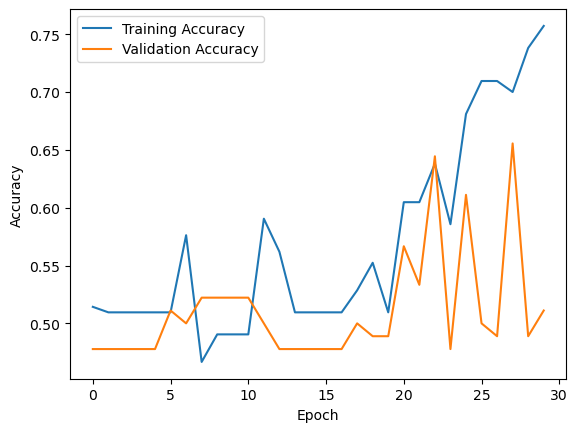

<Figure size 640x480 with 0 Axes>

In [18]:
sns.lineplot(x = cnn_lstm_model_history.epoch,y = cnn_lstm_model_train_accuracy,label = "Training Accuracy")
sns.lineplot(x = cnn_lstm_model_history.epoch,y = cnn_lstm_model_val_accuracy,label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig("cnn_lstm_model_acc.png")

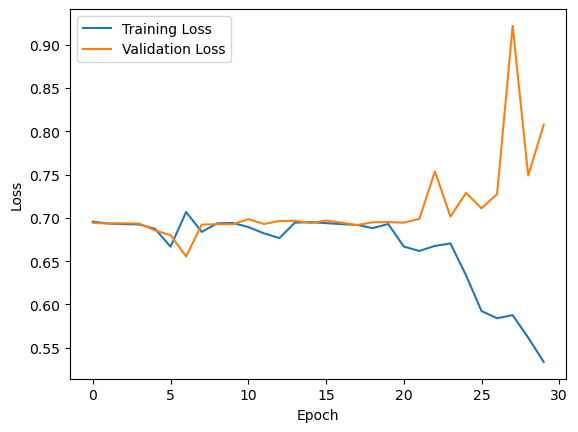

<Figure size 640x480 with 0 Axes>

In [19]:
sns.lineplot(x = cnn_lstm_model_history.epoch,y = cnn_lstm_model_train_loss,label = "Training Loss")
sns.lineplot(x = cnn_lstm_model_history.epoch,y = cnn_lstm_model_val_loss,label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("cnn_lstm_model_loss.png")

# Prediction

In [26]:
test_path = "fight-detection-surv-dataset/fight/fi002.mp4"
test_frame = frame_extraction(test_path)

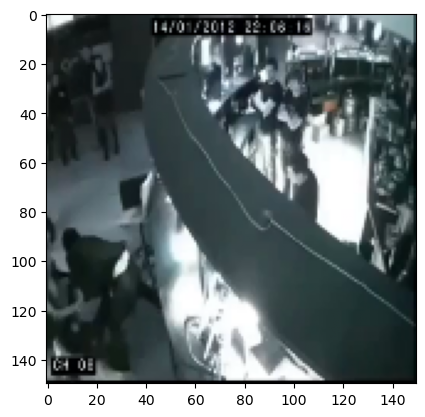

In [28]:
expanded_frame = np.expand_dims(test_frame,axis = 0)
plt.imshow(expanded_frame[0][1])
plt.show()

In [30]:
predicted_class = cnn_lstm_model.predict(expanded_frame)
predicted_class = predicted_class.argmax()
if predicted_class == 0:
    print("Fight")
else:
    print("Normal")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
Fight


In [ ]:
def predict_class(test_path):
    class_label = "Normal"
    test_frame = frame_extraction(test_path)
    expanded_frame = np.expand_dims(test_frame,axis = 0)
    predicted_class = cnn_lstm_model.predict(expanded_frame)
    predicted_class = predicted_class.argmax()
    # plt.imshow(expanded_frame[0][1])
    if predicted_class == 0:
        class_label = "Fight"
    else:
        class_label = "Normal"
    cv2.putText(expanded_frame[0][1], class_label,LABEL_POSITION, LABEL_FONT,LABEL_FONT_SIZE, LABEL_COLOR,LABEL_THICKNESS, cv2.LINE_AA)
    cv2.imshow('Image with Label',expanded_frame[0][1] )
    cv2.waitKey(0)  # Wait for a key press to close the window
    cv2.destroyAllWindows()
    # plt.text(x=10, y=20, s=class_label, color='white', fontsize=14,bbox=dict(facecolor='blue', alpha=0.7))  # Background color and transparency for better visibility
    # plt.axis(False)
predict_class(test_path=test_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


QObject::moveToThread: Current thread (0xfee62d0) is not the object's thread (0xfc7b8b0).
Cannot move to target thread (0xfee62d0)

QObject::moveToThread: Current thread (0xfee62d0) is not the object's thread (0xfc7b8b0).
Cannot move to target thread (0xfee62d0)

QObject::moveToThread: Current thread (0xfee62d0) is not the object's thread (0xfc7b8b0).
Cannot move to target thread (0xfee62d0)

QObject::moveToThread: Current thread (0xfee62d0) is not the object's thread (0xfc7b8b0).
Cannot move to target thread (0xfee62d0)

QObject::moveToThread: Current thread (0xfee62d0) is not the object's thread (0xfc7b8b0).
Cannot move to target thread (0xfee62d0)

QObject::moveToThread: Current thread (0xfee62d0) is not the object's thread (0xfc7b8b0).
Cannot move to target thread (0xfee62d0)

QObject::moveToThread: Current thread (0xfee62d0) is not the object's thread (0xfc7b8b0).
Cannot move to target thread (0xfee62d0)

QObject::moveToThread: Current thread (0xfee62d0) is not the object's thread